VaR & Expected Shortfall Risk Dashboard
Fetching data for AAPL from 2023-11-29 to 2025-11-28...
Successfully fetched 501 trading days of data
Calculated 500 daily returns
Mean Return: 0.0783%
Return Volatility: 1.7553%

RISK METRICS FOR AAPL
Confidence Level: 95.0%

Value-at-Risk (VaR):
  Historical Simulation: 2.7421%
  Parametric Normal:     2.8089%
  Parametric t-Dist:     2.3942% (df=2.75)

Expected Shortfall (ES):
  Historical Simulation: 4.0219%
  Parametric Normal:     3.5424%
  Parametric t-Dist:     3.6719%

Generating visualizations...


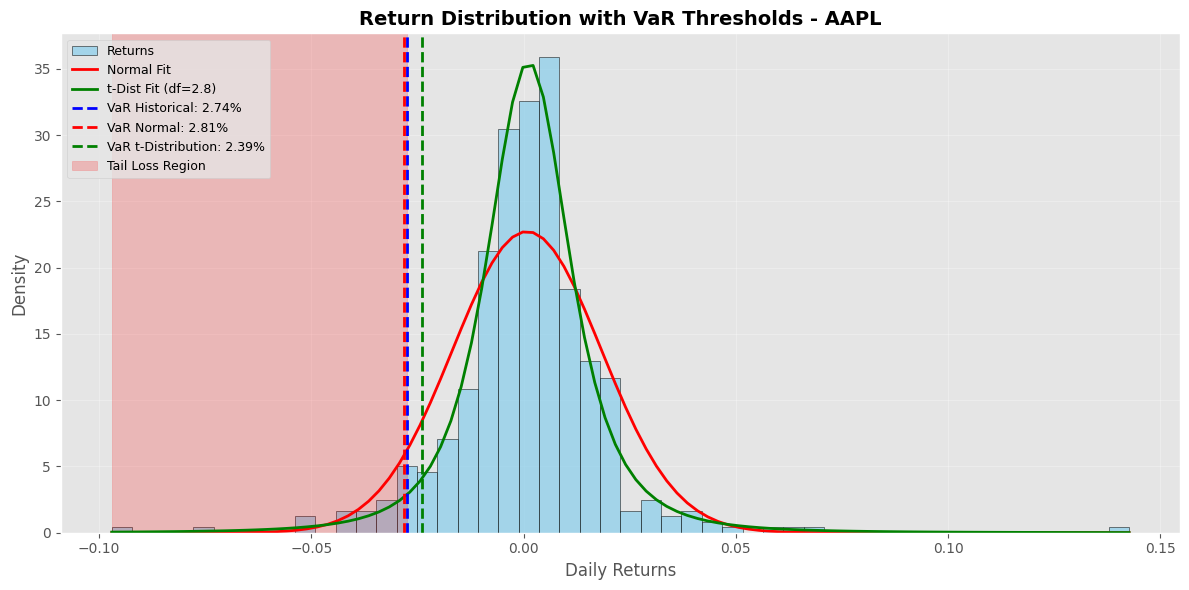

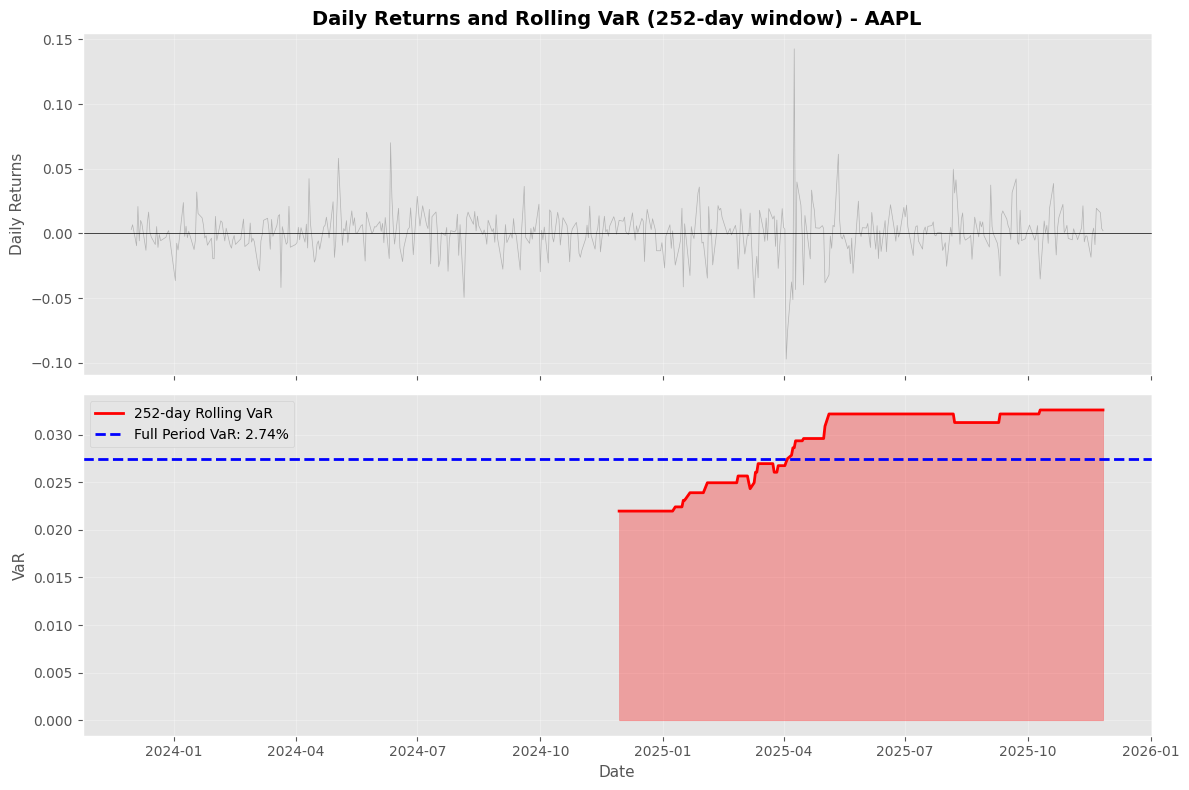

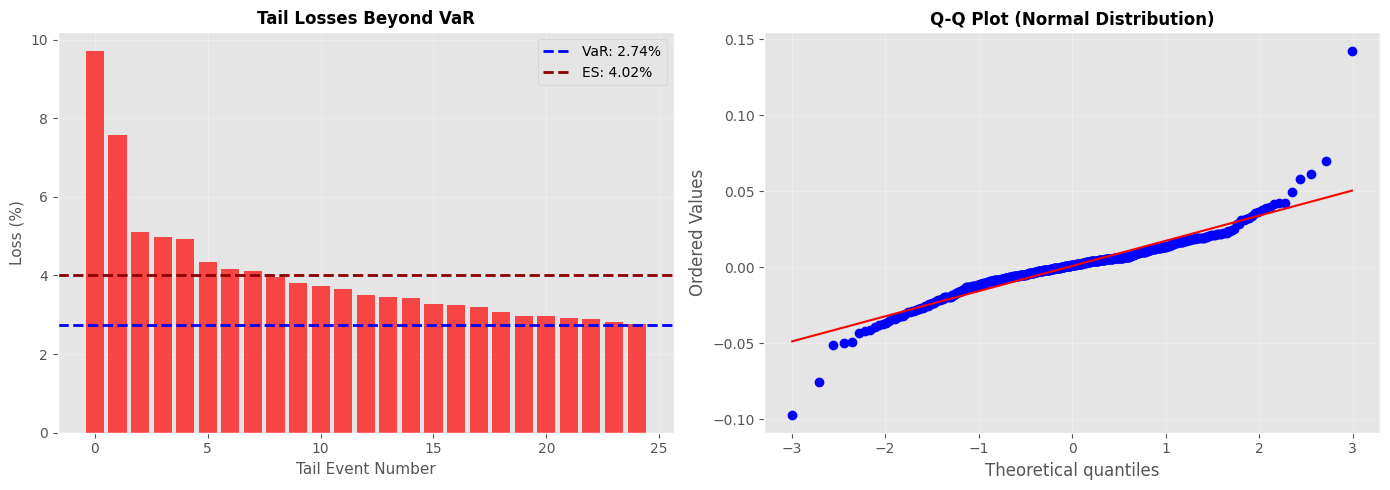

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
from datetime import datetime, timedelta
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')

class VaRDashboard:
    """
    Value-at-Risk (VaR) and Expected Shortfall (ES) Dashboard
    Implements Historical Simulation, Parametric Normal, and t-Distribution methods
    """

    def __init__(self, ticker, start_date=None, end_date=None, confidence_level=0.95):
        """
        Initialize VaR Dashboard

        Parameters:
        -----------
        ticker : str
            Stock ticker symbol (e.g., 'AAPL', '^NSEI' for NIFTY50)
        start_date : str, optional
            Start date in 'YYYY-MM-DD' format (default: 2 years ago)
        end_date : str, optional
            End date in 'YYYY-MM-DD' format (default: today)
        confidence_level : float
            Confidence level for VaR (default: 0.95 for 95%)
        """
        self.ticker = ticker
        self.confidence_level = confidence_level
        self.alpha = 1 - confidence_level

        # Set default dates
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')
        if start_date is None:
            start_date = (datetime.now() - timedelta(days=730)).strftime('%Y-%m-%d')

        self.start_date = start_date
        self.end_date = end_date

        # Initialize data containers
        self.data = None
        self.returns = None
        self.var_results = {}
        self.es_results = {}

    def fetch_data(self):
        """Fetch historical price data from Yahoo Finance"""
        print(f"Fetching data for {self.ticker} from {self.start_date} to {self.end_date}...")

        try:
            # Download data
            data = yf.download(self.ticker, start=self.start_date, end=self.end_date, progress=False)

            if data.empty:
                raise ValueError(f"No data found for ticker {self.ticker}")

            # Flatten MultiIndex columns if present
            if isinstance(data.columns, pd.MultiIndex):
                data.columns = data.columns.get_level_values(0)

            self.data = data
            print(f"Successfully fetched {len(self.data)} trading days of data")
            return self.data

        except Exception as e:
            print(f"Error fetching data: {e}")
            return None

    def calculate_returns(self):
        """Calculate daily log returns"""
        if self.data is None:
            print("No data available. Please fetch data first.")
            return None

        # Use adjusted close for calculations, fallback to Close if not available
        if 'Adj Close' in self.data.columns:
            prices = self.data['Adj Close']
        elif 'Close' in self.data.columns:
            prices = self.data['Close']
        else:
            raise ValueError("No price data found in columns")

        # Calculate log returns
        self.returns = np.log(prices / prices.shift(1)).dropna()

        # Ensure we have a Series, not DataFrame
        if isinstance(self.returns, pd.DataFrame):
            self.returns = self.returns.squeeze()

        mean_ret = float(self.returns.mean())
        std_ret = float(self.returns.std())

        print(f"Calculated {len(self.returns)} daily returns")
        print(f"Mean Return: {mean_ret:.4%}")
        print(f"Return Volatility: {std_ret:.4%}")

        return self.returns

    def historical_var(self):
        """Calculate VaR using Historical Simulation"""
        returns_array = np.array(self.returns)
        var = float(-np.percentile(returns_array, self.alpha * 100))
        self.var_results['Historical'] = var
        return var

    def parametric_normal_var(self):
        """Calculate VaR using Parametric Normal Distribution"""
        mu = float(self.returns.mean())
        sigma = float(self.returns.std())
        var = float(-(mu + sigma * stats.norm.ppf(self.alpha)))
        self.var_results['Normal'] = var
        return var

    def parametric_t_var(self):
        """Calculate VaR using Parametric t-Distribution"""
        mu = float(self.returns.mean())
        sigma = float(self.returns.std())

        # Fit t-distribution to returns
        returns_array = np.array(self.returns)
        params = stats.t.fit(returns_array)
        df, loc, scale = params

        var = float(-(loc + scale * stats.t.ppf(self.alpha, df)))
        self.var_results['t-Distribution'] = var

        return var, df

    def calculate_expected_shortfall(self):
        """Calculate Expected Shortfall (ES) for all methods"""
        # Historical ES
        historical_var = self.var_results.get('Historical', self.historical_var())
        tail_losses = self.returns[self.returns <= -historical_var]
        self.es_results['Historical'] = -tail_losses.mean() if len(tail_losses) > 0 else historical_var

        # Normal ES
        mu = self.returns.mean()
        sigma = self.returns.std()
        self.es_results['Normal'] = -(mu - sigma * stats.norm.pdf(stats.norm.ppf(self.alpha)) / self.alpha)

        # t-Distribution ES
        params = stats.t.fit(self.returns)
        df, loc, scale = params
        t_var = self.var_results.get('t-Distribution', self.parametric_t_var()[0])
        t_tail = self.returns[self.returns <= -t_var]
        self.es_results['t-Distribution'] = -t_tail.mean() if len(t_tail) > 0 else t_var

        return self.es_results

    def calculate_all_metrics(self):
        """Calculate all VaR and ES metrics"""
        print("\n" + "="*60)
        print(f"RISK METRICS FOR {self.ticker}")
        print(f"Confidence Level: {self.confidence_level:.1%}")
        print("="*60)

        # Calculate VaR
        hist_var = self.historical_var()
        norm_var = self.parametric_normal_var()
        t_var, df = self.parametric_t_var()

        # Calculate ES
        self.calculate_expected_shortfall()

        # Display results
        print("\nValue-at-Risk (VaR):")
        print(f"  Historical Simulation: {hist_var:.4%}")
        print(f"  Parametric Normal:     {norm_var:.4%}")
        print(f"  Parametric t-Dist:     {t_var:.4%} (df={df:.2f})")

        print("\nExpected Shortfall (ES):")
        print(f"  Historical Simulation: {self.es_results['Historical']:.4%}")
        print(f"  Parametric Normal:     {self.es_results['Normal']:.4%}")
        print(f"  Parametric t-Dist:     {self.es_results['t-Distribution']:.4%}")
        print("="*60)

        return self.var_results, self.es_results

    def plot_return_distribution(self):
        """Plot return histogram with VaR and ES lines"""
        fig, ax = plt.subplots(figsize=(12, 6))

        # Plot histogram
        n, bins, patches = ax.hist(self.returns, bins=50, density=True, alpha=0.7,
                                   color='skyblue', edgecolor='black', label='Returns')

        # Plot normal distribution fit
        mu, sigma = self.returns.mean(), self.returns.std()
        x = np.linspace(self.returns.min(), self.returns.max(), 100)
        ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Fit')

        # Plot t-distribution fit
        params = stats.t.fit(self.returns)
        df, loc, scale = params
        ax.plot(x, stats.t.pdf(x, df, loc, scale), 'g-', linewidth=2, label=f't-Dist Fit (df={df:.1f})')

        # Plot VaR lines
        colors = {'Historical': 'blue', 'Normal': 'red', 't-Distribution': 'green'}
        for method, var in self.var_results.items():
            ax.axvline(-var, color=colors[method], linestyle='--', linewidth=2,
                      label=f'VaR {method}: {var:.2%}')

        # Highlight tail region
        tail_threshold = -self.var_results['Historical']
        ax.axvspan(self.returns.min(), tail_threshold, alpha=0.2, color='red', label='Tail Loss Region')

        ax.set_xlabel('Daily Returns', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_title(f'Return Distribution with VaR Thresholds - {self.ticker}', fontsize=14, fontweight='bold')
        ax.legend(loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    def plot_rolling_var(self, window=252):
        """Plot rolling VaR time series"""
        rolling_returns = self.returns.rolling(window=window)

        # Calculate rolling VaR (Historical)
        rolling_var = rolling_returns.apply(lambda x: -np.percentile(x.dropna(), self.alpha * 100))

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        # Plot returns
        ax1.plot(self.returns.index, self.returns, color='gray', alpha=0.5, linewidth=0.5)
        ax1.axhline(0, color='black', linestyle='-', linewidth=0.5)
        ax1.set_ylabel('Daily Returns', fontsize=11)
        ax1.set_title(f'Daily Returns and Rolling VaR ({window}-day window) - {self.ticker}',
                     fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)

        # Plot rolling VaR
        ax2.plot(rolling_var.index, rolling_var, color='red', linewidth=2, label=f'{window}-day Rolling VaR')
        ax2.fill_between(rolling_var.index, 0, rolling_var, alpha=0.3, color='red')
        ax2.axhline(self.var_results['Historical'], color='blue', linestyle='--',
                   linewidth=2, label=f'Full Period VaR: {self.var_results["Historical"]:.2%}')
        ax2.set_xlabel('Date', fontsize=11)
        ax2.set_ylabel('VaR', fontsize=11)
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    def plot_tail_analysis(self):
        """Plot tail loss analysis"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Left plot: Tail losses
        historical_var = self.var_results['Historical']
        tail_losses = self.returns[self.returns <= -historical_var].sort_values()

        ax1.bar(range(len(tail_losses)), -tail_losses * 100, color='red', alpha=0.7)
        ax1.axhline(historical_var * 100, color='blue', linestyle='--', linewidth=2,
                   label=f'VaR: {historical_var:.2%}')
        ax1.axhline(self.es_results['Historical'] * 100, color='darkred', linestyle='--',
                   linewidth=2, label=f'ES: {self.es_results["Historical"]:.2%}')
        ax1.set_xlabel('Tail Event Number', fontsize=11)
        ax1.set_ylabel('Loss (%)', fontsize=11)
        ax1.set_title('Tail Losses Beyond VaR', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Right plot: QQ plot
        stats.probplot(self.returns, dist="norm", plot=ax2)
        ax2.set_title('Q-Q Plot (Normal Distribution)', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    def generate_pdf_report(self, filename=None):
        """Generate comprehensive PDF risk report"""
        if filename is None:
            filename = f"VaR_Report_{self.ticker}_{datetime.now().strftime('%Y%m%d')}.pdf"

        with PdfPages(filename) as pdf:
            # Page 1: Distribution plot
            fig1 = self.plot_return_distribution()
            pdf.savefig(fig1, bbox_inches='tight')
            plt.close()

            # Page 2: Rolling VaR
            fig2 = self.plot_rolling_var()
            pdf.savefig(fig2, bbox_inches='tight')
            plt.close()

            # Page 3: Tail analysis
            fig3 = self.plot_tail_analysis()
            pdf.savefig(fig3, bbox_inches='tight')
            plt.close()

            # Page 4: Summary statistics
            fig4, ax = plt.subplots(figsize=(11, 8))
            ax.axis('off')

            summary_text = f"""
            RISK REPORT SUMMARY
            {'='*70}

            Ticker: {self.ticker}
            Period: {self.start_date} to {self.end_date}
            Confidence Level: {self.confidence_level:.1%}

            RETURN STATISTICS
            {'-'*70}
            Number of Observations: {len(self.returns)}
            Mean Daily Return: {self.returns.mean():.4%}
            Daily Volatility: {self.returns.std():.4%}
            Annualized Volatility: {self.returns.std() * np.sqrt(252):.4%}
            Skewness: {self.returns.skew():.4f}
            Kurtosis: {self.returns.kurtosis():.4f}
            Min Return: {self.returns.min():.4%}
            Max Return: {self.returns.max():.4%}

            VALUE-AT-RISK (VaR)
            {'-'*70}
            Historical Simulation: {self.var_results['Historical']:.4%}
            Parametric Normal: {self.var_results['Normal']:.4%}
            Parametric t-Distribution: {self.var_results['t-Distribution']:.4%}

            EXPECTED SHORTFALL (ES)
            {'-'*70}
            Historical Simulation: {self.es_results['Historical']:.4%}
            Parametric Normal: {self.es_results['Normal']:.4%}
            Parametric t-Distribution: {self.es_results['t-Distribution']:.4%}

            INTERPRETATION
            {'-'*70}
            At {self.confidence_level:.0%} confidence level:
            - There is a {self.alpha:.0%} probability of losing more than
              {self.var_results['Historical']:.2%} in a single day
            - If losses exceed VaR, the expected loss is
              {self.es_results['Historical']:.2%} (Expected Shortfall)

            Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
            """

            ax.text(0.1, 0.9, summary_text, transform=ax.transAxes,
                   fontsize=10, verticalalignment='top', fontfamily='monospace')

            pdf.savefig(fig4, bbox_inches='tight')
            plt.close()

        print(f"\nPDF report saved as: {filename}")
        return filename


# Main execution
if __name__ == "__main__":
    # Example usage
    print("VaR & Expected Shortfall Risk Dashboard")
    print("="*60)

    # Initialize dashboard for a stock (e.g., Apple)
    ticker = "AAPL"  # Change to "^NSEI" for NIFTY50, or any other ticker
    dashboard = VaRDashboard(ticker=ticker, confidence_level=0.95)

    # Fetch data and calculate returns
    dashboard.fetch_data()
    dashboard.calculate_returns()

    # Calculate all risk metrics
    var_results, es_results = dashboard.calculate_all_metrics()

    # Generate visualizations
    print("\nGenerating visualizations...")
    dashboard.plot_return_distribution()
    dashboard.plot_rolling_var(window=252)
    dashboard.plot_tail_analysis()
    plt.show()


In [9]:
pip freeze > requirements.txt
